# Starter Code for Drug Experience Team Project

In this notebook, we build two machine learning models to predict the severity of a medication. The target variable is a binary variable. We first build a gradient boosting machine. Then we build a LSTM classifier. We use each one of the two models to create the submission files for Kaggle.  

In [1]:
# Import packages:

import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from custom_funcs import *

# sklearn imports:
import sklearn
from sklearn import tree
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# tensorflow imports:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# keras imports:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

# import and load spaCy:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import displacy
# spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm') 

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

## 1. Read the Data Files

In [37]:
df = pd.read_csv('data/orig_DrugExp_Text.csv', sep='|')
df.head()

,label,text
0,-1,Schizophrenia Only been on it one day. I took ...
1,-1,Cancer drug arimidex gave me osteoporosis Took...
2,-1,Osteoporosis Dysphagia (inability to swallow)....
3,-1,Ostoclerosis Took it at 630 am by 230pm receiv...
4,-1,Osteopenia My limbs feel like I have weights t...


By looking at the shape of the data file, we realize that we have 9523 samples and two columns:

In [38]:
df.shape

(9523, 2)

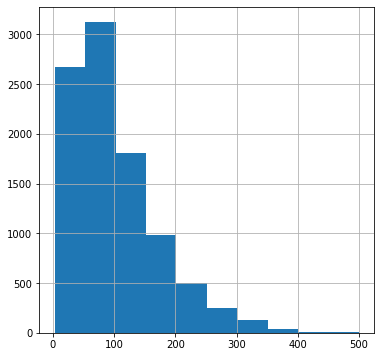

In [39]:
df['word_count'] = df.text.apply(lambda x:len(x.split()))
df.word_count.hist()

The target variable is a binary variable called label, which has two possible values: -1 for negative experience and 1 for positive experience: 

In [40]:
df.label.value_counts()

-1    5072
 1    4451
Name: label, dtype: int64

## 2. Pre-processing

spaCy:
* tokenize
* lemmatize
* remove stop words
* keep alphabetical characters:

In [41]:
# tqdm.pandas()
# df['text'] = df.text.progress_apply(lambda text: 
#                                           " ".join(token.lemma_ for token in nlp(text) 
#                                                    if not token.is_stop and token.is_alpha))

# Save the file with pre-processed text for later use:

# df.to_csv('data/orig_DrugExp_Text_Clean.csv', sep='|', index=False)

Given that pre-processing the text is a time-consuming process, we can save the cleaned data for later use:

In [44]:
df = pd.read_csv("data/orig_DrugExp_Text_Clean.csv", sep = "|")


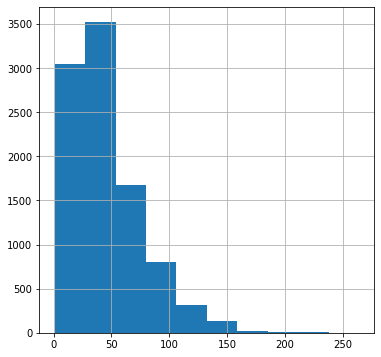

In [45]:
df['word_count'] = df.text.apply(lambda x:len(x.split()))
df.word_count.hist()

In [43]:
df.head()

,label,text
0,-1,Schizophrenia day take morning direct sleep da...
1,-1,cancer drug arimidex give osteoporosis Took ac...
2,-1,Osteoporosis Dysphagia inability swallow sever...
3,-1,Ostoclerosis take receive sharp pain rt hip la...
4,-1,Osteopenia limb feel like weight tie fever chi...


# 3. Vectorization

We can now use CountVectorizer or TfidfVectorizer to create the document-term-matrix (DTM):

In [105]:
# vectorizer = CountVectorizer(min_df=10)
vectorizer = TfidfVectorizer(min_df=10, # minimum number of times a word should appear in the data to be included
                             ngram_range=(1,2) # use both unigrams (single words) and bigrams (two-word phrases)
                            )
x = vectorizer.fit_transform(df.text)

In [106]:
len(vectorizer.vocabulary_)

6804

In [107]:
# vectorizer.vocabulary_

## 4. Train and Test the Classifier

In [108]:
# trainData, testData, trainLabels, testLabels = train_test_split(x, df.label.values, 
#                                                                 test_size=.2,
#                                                                 random_state = 1)

### 4.2. LSTM Model

Now we can go ahead and build a LSTM model instead of GBM. We first separate the text from the labels:

In [109]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

We then split the data to train/ test:

In [110]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 1)

We prepare the text data that will be received in the input layer:

In [111]:
max_words = 7000 # maximum number of words to be used in the analysis (vocabulary_len)
max_len = 175 # maximum length of each document (maximum number of words allowed in each document - use histogram)
tok = Tokenizer(num_words=max_words) # create the tokenizer
tok.fit_on_texts(X_train) # fit the tokenizer
sequences = tok.texts_to_sequences(X_train) # apply the tokenizer to the data
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #pads sequences

In [112]:
len(sequences)

7618

In [113]:
# sequences[0] # a sentence 

Now we can use Keras to design our model:

In [124]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs) 
    layer = LSTM(150)(layer)
    layer = Dense(150,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.15)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Now we can compile our model:

In [125]:
# Clear previous model:
clear_session()

lstm_model = RNN()
lstm_model.summary()
lstm_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['AUC'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 175)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 175, 50)           350000    
_________________________________________________________________
lstm (LSTM)                  (None, 150)               120600    
_________________________________________________________________
FC1 (Dense)                  (None, 150)               22650     
_________________________________________________________________
activation (Activation)      (None, 150)               0         
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 151   

Now we can fit our model using our data:

In [126]:
lstm_model.fit(sequences_matrix,
               Y_train,
               batch_size=5, # Really means number of batches  (divide all samples by batch size to get size of each batch)
               # IF you raise your batch_size,you are feeding less observations, it will be worse...
               # Use a large batch size when tuning, then turn it down
               epochs=10, # Increasing the epochs, the whole process is going to happen that many times
               validation_split=0.2,
               callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
1219/1219 [==============================] - 134s 109ms/step - loss: 0.6202 - auc: 0.7101 - val_loss: 0.4454 - val_auc: 0.8813
Epoch 2/10
1219/1219 [==============================] - 130s 107ms/step - loss: 0.3974 - auc: 0.9029 - val_loss: 0.4535 - val_auc: 0.8875


To evaluate our model, we need to process the test data the same way we processed our train data:

In [127]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

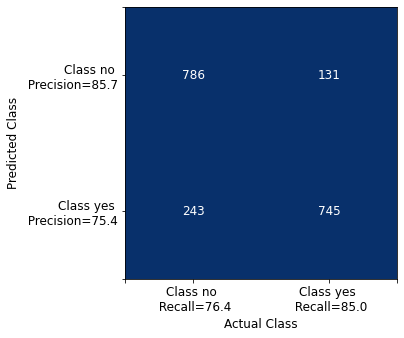

In [128]:
predictions = (lstm_model.predict(test_sequences_matrix) > 0.5).astype("int32").flatten() # Get the prediction labels

confusionMatrix = None # Remove any previously created confusion matrix
confusionMatrix = confusion_matrix(Y_test, predictions) # Create new confusion matrix
plt.rcParams['figure.figsize'] = (5, 5) # Determine the size of the plot
displayConfusionMatrix(confusionMatrix) # Display the plot

AUC Score = 88.450


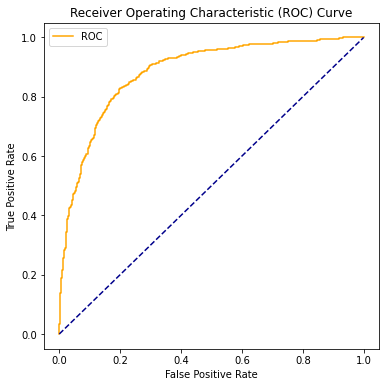

In [129]:
predictionProbabilities = lstm_model.predict(test_sequences_matrix) # Get the prediction probabilities (scores)

fpr, tpr, thresholds = roc_curve(Y_test, predictionProbabilities, pos_label = 1) # Calculate FPR and TPR

lr_auc = roc_auc_score(Y_test, predictionProbabilities) # Calculate AUC score
plt.rcParams['figure.figsize'] = (5, 5) # Determine the size of the plot
custom_plot_roc_curve(fpr, tpr, lr_auc) # Display ROC plot

In [130]:
# from keras.models import load_model

# lstm_model.save('model/drug_ex_model.h5')  # creates a HDF5 file 'my_model.h5'

# # # Load the model:
# # lstm_model = load_model('model/drug_ex_model.h5')

## 5. Apply the Classifier and Submit to Kaggle

Read the data file:

In [131]:
kaggle_test = pd.read_csv("data/test_DrugExp.csv", sep = "|")
kaggle_test.head()

,Id,text
0,1,osteoporosis Took the once a week 35 mg First ...
1,2,"osteoporosis 12 hours after first dose, experi..."
2,3,ADHD i am going crazy i dont sleep and if i do...
3,4,treatment resistant depression none i ll admit...
4,5,Because I felt like it my heartbeat was a litt...


Pre-process the data the same way we did in model building phase:

In [132]:
tqdm.pandas()
kaggle_test['text'] = kaggle_test.text.progress_apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop and token.is_alpha))

/home/greermp/.local/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 2380/2380 [00:28<00:00, 84.79it/s]


Apply the LSTM model and export it:

In [133]:
test_sequences = tok.texts_to_sequences(kaggle_test.text)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

kaggle_test['Expected'] = lstm_model.predict(test_sequences_matrix)
to_kaggle = kaggle_test[['Id','Expected']]

to_kaggle.to_csv('result/to_Kaggle_lstm_model.csv', index=False)

Submit the file to https://www.kaggle.com/t/25177e2258c2412cae4924fa4a8777e8 

* kaggle competitions submit -c drug-experience -f result/to_Kaggle_lstm_model.csv -m "test"

Best so far is 88.217